In [1]:
!kaggle datasets download -d masud1901/binary-classification-data-for-apnea-detection
!unzip binary-classification-data-for-apnea-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: Binary_Classification_Apnea/non_apnea/22555.png  
  inflating: Binary_Classification_Apnea/non_apnea/22556.png  
  inflating: Binary_Classification_Apnea/non_apnea/22557.png  
  inflating: Binary_Classification_Apnea/non_apnea/22558.png  
  inflating: Binary_Classification_Apnea/non_apnea/22559.png  
  inflating: Binary_Classification_Apnea/non_apnea/22560.png  
  inflating: Binary_Classification_Apnea/non_apnea/22566.png  
  inflating: Binary_Classification_Apnea/non_apnea/22567.png  
  inflating: Binary_Classification_Apnea/non_apnea/22568.png  
  inflating: Binary_Classification_Apnea/non_apnea/22569.png  
  inflating: Binary_Classification_Apnea/non_apnea/22571.png  
  inflating: Binary_Classification_Apnea/non_apnea/22572.png  
  inflating: Binary_Classification_Apnea/non_apnea/22573.png  
  inflating: Binary_Classification_Apnea/non_apnea/22575.png  
  inflating: Binary_Classification_Apnea/non_apnea/22576.png  
  in

In [2]:
import os
import random
import cv2
import numpy as np
from tqdm import tqdm

def process_spectrogram(image):
    # Convert to grayscale if it's not already
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Ensure the image is not empty and contains valid data
    if gray.size == 0 or np.all(gray == gray[0, 0]):
        return None

    # Convert to float32 for processing
    gray = gray.astype(np.float32)

    # Apply log transformation to enhance low intensity features
    # Add a small constant to avoid log(0)
    epsilon = 1e-5
    log_transformed = np.log1p(gray + epsilon)

    # Normalize to 0-1 range
    normalized = (log_transformed - np.min(log_transformed)) / (np.max(log_transformed) - np.min(log_transformed))

    # Convert to 8-bit (0-255 range)
    normalized = (normalized * 255).astype(np.uint8)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(normalized)

    # Apply median filtering to reduce noise while preserving edges
    result = cv2.medianBlur(enhanced, 3)

    return result

def process_directory(input_dir, sample_size):
    all_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
    sampled_files = random.sample(all_files, min(sample_size, len(all_files)))

    for filename in tqdm(sampled_files, desc=f"Processing {os.path.basename(input_dir)}"):
        file_path = os.path.join(input_dir, filename)
        try:
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            if image is not None:
                processed = process_spectrogram(image)
                if processed is not None:
                    cv2.imwrite(file_path, processed)
                else:
                    print(f"Skipping {filename} due to invalid data")
                    os.remove(file_path)
            else:
                print(f"Failed to read {filename}")
                os.remove(file_path)
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            os.remove(file_path)

    # Delete unprocessed images
    for filename in all_files:
        if filename not in sampled_files:
            os.remove(os.path.join(input_dir, filename))

def main():
    base_dir = "./Binary_Classification_Apnea"
    apnea_dir = os.path.join(base_dir, "apnea")
    non_apnea_dir = os.path.join(base_dir, "non_apnea")

    # Count the number of images in each directory
    apnea_count = len([f for f in os.listdir(apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
    non_apnea_count = len([f for f in os.listdir(non_apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

    # Use the smaller count as the sample size
    sample_size = min(apnea_count, non_apnea_count)

    print(f"Processing {sample_size} spectrograms from each directory...")

    process_directory(apnea_dir, sample_size)
    process_directory(non_apnea_dir, sample_size)

    print("Processing complete.")

if __name__ == "__main__":
    main()

Processing 6999 spectrograms from each directory...


Processing non_apnea: 100%|██████████| 6999/6999 [00:16<00:00, 431.18it/s]


Processing complete.


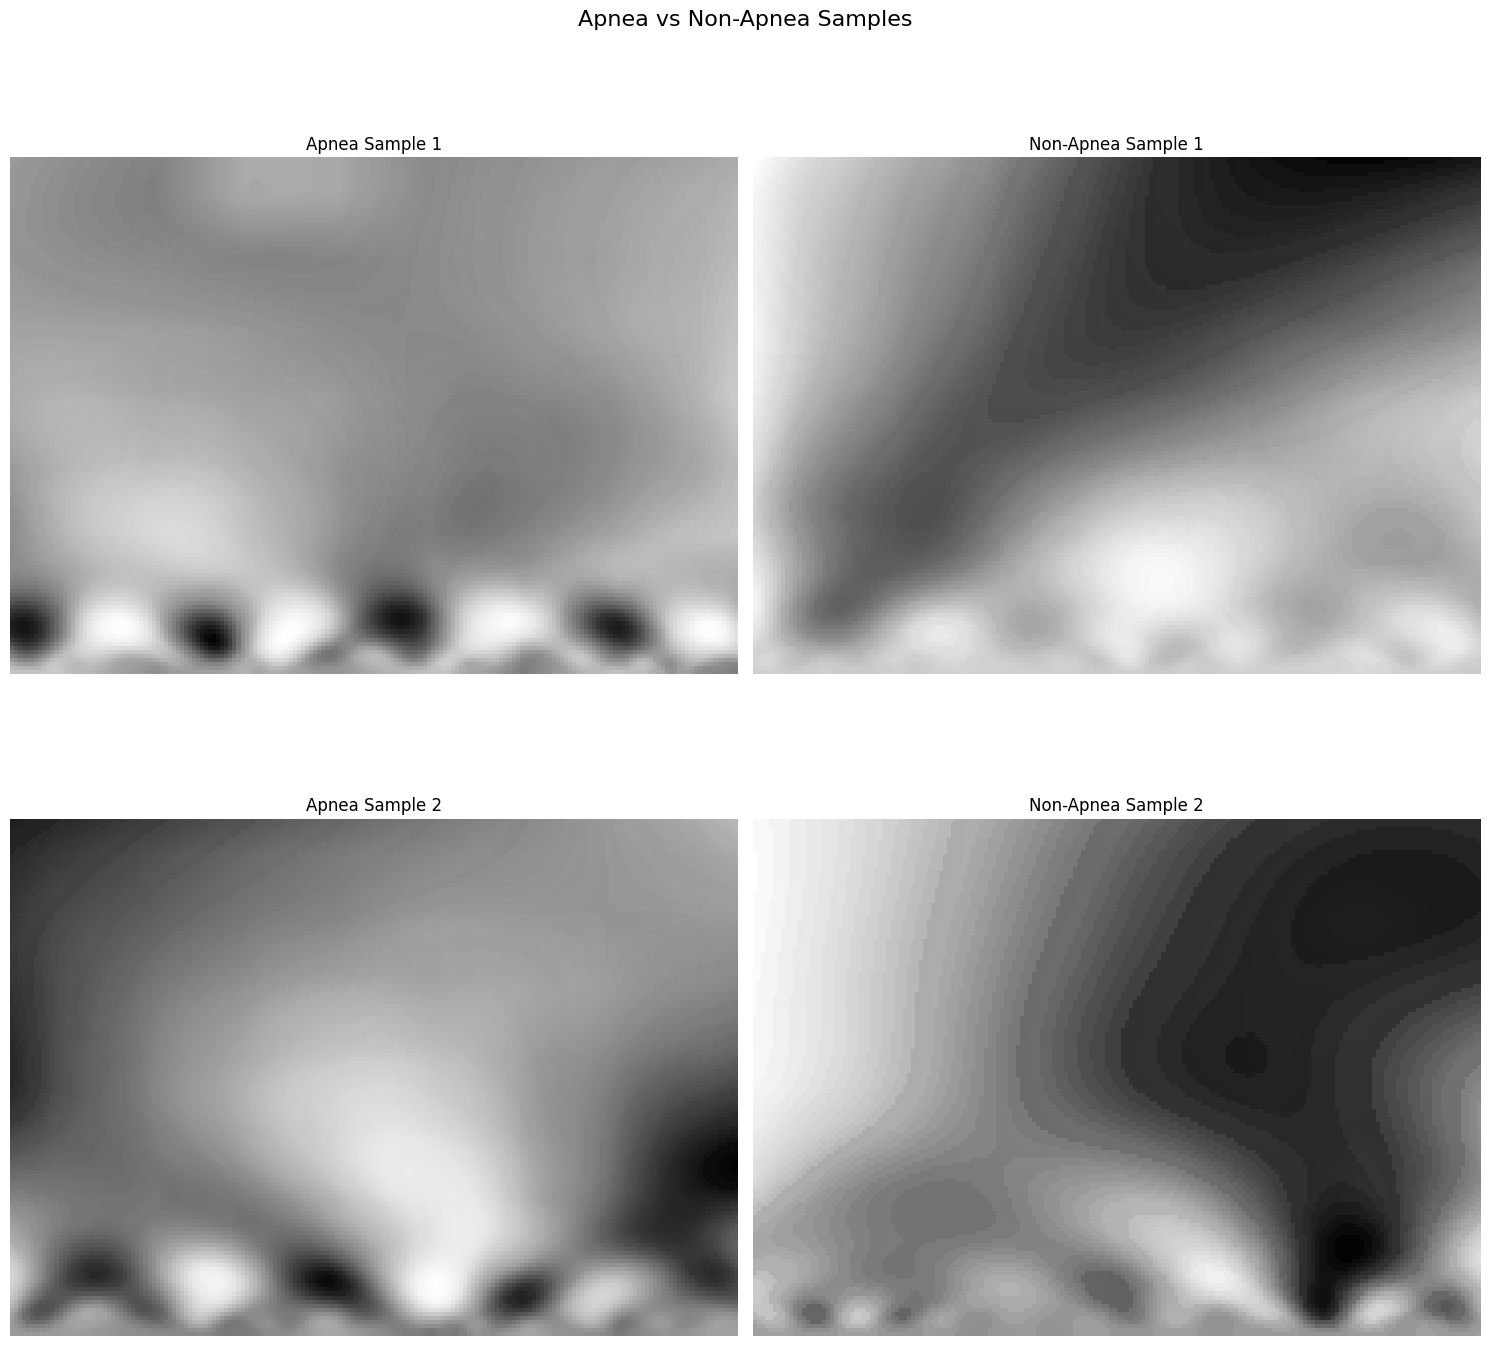

In [3]:
import os
import random
import matplotlib.pyplot as plt
import cv2

def display_samples(base_dir, num_samples=2):
    apnea_dir = os.path.join(base_dir, "apnea")
    non_apnea_dir = os.path.join(base_dir, "non_apnea")

    # Get random samples
    apnea_samples = random.sample([f for f in os.listdir(apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))], num_samples)
    non_apnea_samples = random.sample([f for f in os.listdir(non_apnea_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))], num_samples)

    # Set up the plot
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle("Apnea vs Non-Apnea Samples", fontsize=16)

    # Display apnea samples
    for i, sample in enumerate(apnea_samples):
        img = cv2.imread(os.path.join(apnea_dir, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, 0].imshow(img)
        axs[i, 0].set_title(f"Apnea Sample {i+1}")
        axs[i, 0].axis('off')

    # Display non-apnea samples
    for i, sample in enumerate(non_apnea_samples):
        img = cv2.imread(os.path.join(non_apnea_dir, sample))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, 1].imshow(img)
        axs[i, 1].set_title(f"Non-Apnea Sample {i+1}")
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Print the filenames
    print("Apnea Samples:")
    for sample in apnea_samples:
        print(f"- {sample}")
    print("\nNon-Apnea Samples:")
    for sample in non_apnea_samples:
        print(f"- {sample}")

# Replace this with the path to your dataset folder
base_dir = "/content/Binary_Classification_Apnea"
display_samples(base_dir)

In [4]:
!pip install split-folders

Apnea Samples:
- 15088.png
- 7213.png

Non-Apnea Samples:
- 7514.png
- 1318.png


In [5]:
import splitfolders

# Path to your dataset
input_folder = '/content/Binary_Classification_Apnea'

# Output folder
output_folder = '/content/Dataset'

# Split the dataset (train: 80%, val: 10%, test: 10%)
splitfolders.ratio(input_folder, output=output_folder, seed=17, ratio=(.8, .1, .1))

Copying files: 13998 files [00:02, 5502.70 files/s]


In [6]:
import numpy as np
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, BatchNormalization, Dropout, Flatten, Reshape
from tensorflow.keras.optimizers import Adam


In [7]:
train_path = '/content/Dataset/train'
val_path = '/content/Dataset/val'
test_path = '/content/Dataset/test'

In [8]:
# Get the number of files and classes
train_image_files = glob.glob(train_path + '/*/*.png')
val_image_files = glob.glob(val_path + '/*/*.png')
test_image_files = glob.glob(test_path + '/*/*.png')


In [9]:
num_train_images = len(train_image_files)
num_val_images = len(val_image_files)
num_test_images = len(test_image_files)


In [10]:
folders = glob.glob(train_path + '/*')
num_classes = len(folders)

# Parameters
img_height, img_width = 128, 180  # Resizing the images
batch_size = 256
epochs = 100


In [11]:
# Image data generators for training, validation, and testing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 11198 images belonging to 2 classes.
Found 1398 images belonging to 2 classes.
Found 1402 images belonging to 2 classes.


In [13]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
import datetime
import os
import numpy as np

# Define early stopping with restoration of best weights
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Define model checkpointing with multiple saves
checkpoint_path = "checkpoints/model_{epoch:02d}-{val_loss:.2f}.keras"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    # period=5,
    verbose=1
)

# Define TensorBoard callback with more metrics
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=1
)

# Define ReduceLROnPlateau callback with cooldown
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-7,
    cooldown=5,
    verbose=1
)

# Define CSVLogger callback with append mode
csv_logger = CSVLogger('training.log', append=True, separator=',')

# Define an improved LearningRateScheduler callback
def cosine_decay_with_warmup(epoch, total_epochs, warmup_epochs, base_lr, min_lr):
    if epoch < warmup_epochs:
        return base_lr * ((epoch + 1) / warmup_epochs)
    else:
        return min_lr + 0.5 * (base_lr - min_lr) * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))

total_epochs = 100  # Adjust this based on your training plan
warmup_epochs = 5
base_lr = 0.01
min_lr = 1e-6

lr_scheduler_callback = LearningRateScheduler(
    lambda epoch: cosine_decay_with_warmup(epoch, total_epochs, warmup_epochs, base_lr, min_lr),
    verbose=1
)

# Add a TerminateOnNaN callback
terminate_on_nan = tf.keras.callbacks.TerminateOnNaN()

# Add a custom callback for logging memory usage
class MemoryLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        try:
            import psutil
            memory = psutil.virtual_memory()
            print(f"\nEpoch {epoch}: Memory usage: {memory.percent}%")
        except ImportError:
            print("psutil not installed. Unable to log memory usage.")

memory_logger = MemoryLogger()

# Combine all callbacks
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback,
    reduce_lr,
    csv_logger,
    lr_scheduler_callback,
    terminate_on_nan,
    memory_logger
]

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout, Add, Concatenate
)
from tensorflow.keras.regularizers import l2

# Residual block
def residual_block(x, filters, strides=1):
    shortcut = x

    # Apply convolution to match the number of filters in the shortcut if needed
    if strides != 1 or tf.keras.backend.int_shape(x)[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Main convolution path
    x = Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Add shortcut (residual connection)
    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x

# Simplified inception module
def inception_module(x, filters_1x1, filters_3x3, filters_pool_proj):
    # 1x1 convolution branch
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', use_bias=False)(x)
    conv_1x1 = BatchNormalization()(conv_1x1)
    conv_1x1 = ReLU()(conv_1x1)

    # 3x3 convolution branch
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', use_bias=False)(x)
    conv_3x3 = BatchNormalization()(conv_3x3)
    conv_3x3 = ReLU()(conv_3x3)

    # Pooling branch followed by 1x1 convolution
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', use_bias=False)(pool_proj)
    pool_proj = BatchNormalization()(pool_proj)
    pool_proj = ReLU()(pool_proj)

    # Concatenate all branches
    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, pool_proj])

    return output

# Create the model
def create_model(input_shape=(128, 180, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Initial convolution block
    x = Conv2D(32, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # First residual block
    x = residual_block(x, filters=64, strides=2)

    # Inception module
    x = inception_module(x, filters_1x1=32, filters_3x3=64, filters_pool_proj=32)

    # Second residual block
    x = residual_block(x, filters=128, strides=2)

    # Inception module
    x = inception_module(x, filters_1x1=64, filters_3x3=128, filters_pool_proj=64)

    # Third residual block
    x = residual_block(x, filters=256, strides=2)

    # Global Average Pooling and Dense layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-5))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    # outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
# Create the model
model = create_model(input_shape=(128, 180, 1), num_classes=2)  # Assuming binary classification (apnea vs. non-apnea)

# Print the model summary
# model.summary()
# model = combined_se_inception_model((img_height, img_width, 1), num_classes)

# For RGB images
# model = create_inception_resnet_gru_model((img_height, img_width, 3), num_classes)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 180, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 90, 32)     │            288 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 90, 32)     │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 90, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 45, 64)     │         18,432 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 45, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 32, 45, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 45, 64)     │         36,864 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 45, 64)     │          2,048 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 45, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 45, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 45, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 45, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 45, 64)     │              0 │ re_lu_2[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 45, 32)     │          2,048 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 45, 64)     │         36,864 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 1,859,106 (7.09 MB)

 Trainable params: 1,855,586 (7.08 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [16]:
r = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=16,
    callbacks=callbacks,  # Add callbacks here
)


Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.7712 - loss: 0.4976
Epoch 1: val_loss improved from inf to 6.18226, saving model to checkpoints/model_01-6.18.keras

Epoch 0: Memory usage: 25.1%
44/44 ━━━━━━━━━━━━━━━━━━━━ 86s 995ms/step - accuracy: 0.7738 - loss: 0.4926 - val_accuracy: 0.3491 - val_loss: 6.1823 - learning_rate: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.004.
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9514 - loss: 0.1315
Epoch 2: val_loss did not improve from 6.18226

Epoch 1: Memory usage: 26.8%
44/44 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.9515 - loss: 0.1311 - val_accuracy: 0.4270 - val_loss: 11.9146 - learning_rate: 0.0040

Epoch 3: LearningRateScheduler setting learning rate to 0.006.
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9611 - loss: 0.0961
Epoch 3: val_loss did not improve from 6.18226

Epoch 2: Memory usage: 28.3%
44/44 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.96

In [18]:
# evaluate model

from tensorflow.keras.models import load_model


model = load_model('/content/checkpoints/model_49-0.05.keras')
evaluation = model.evaluate(train_generator)
evaluation = model.evaluate(val_generator)
evaluation = model.evaluate(test_generator)

44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.9897 - loss: 0.0303
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.9869 - loss: 0.0372
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 968ms/step - accuracy: 0.9855 - loss: 0.0626


In [19]:
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(data_path, N):
    print("Generating confusion matrix for", N, "samples")
    predictions = []
    targets = []
    i = 0
    gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
        data_path,
        target_size=(img_height, img_width),
        batch_size=batch_size * 2,
        class_mode='categorical',
        color_mode='grayscale',
        shuffle=False
    )

    for x, y in gen:
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets[:N], predictions[:N])
    return cm

# Get confusion matrix for the training set
train_cm = get_confusion_matrix(train_path, len(train_image_files))
print(train_cm)

Generating confusion matrix for 11198 samples
Found 11198 images belonging to 2 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step
[[5599    0]
 [ 109 5490]]


In [20]:
val_cm = get_confusion_matrix(val_path, len(val_image_files))
print(val_cm)

Generating confusion matrix for 1398 samples
Found 1398 images belonging to 2 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
[[699   0]
 [ 21 678]]


In [21]:
test_cm = get_confusion_matrix(test_path, len(test_image_files))
print(test_cm)

Generating confusion matrix for 1402 samples
Found 1402 images belonging to 2 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
[[699   2]
 [ 20 681]]


In [22]:
cm = test_cm
# Calculate the total number of predictions
total_predictions = np.sum(cm)

# Calculate the number of correct predictions
correct_predictions = np.trace(cm)

# Calculate Accuracy
accuracy = correct_predictions / total_predictions

# Calculate Precision, Recall, F1-score for each class
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

Accuracy:  0.9843081312410842
Precision:  [0.97218359 0.99707174]
Recall:  [0.99714693 0.97146933]
F1-score:  [0.98450704 0.98410405]


In [23]:
print(test_generator.classes)
print(test_generator.class_indices)

[0 0 0 ... 1 1 1]
{'apnea': 0, 'non_apnea': 1}


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
ROC AUC Score: 0.9997


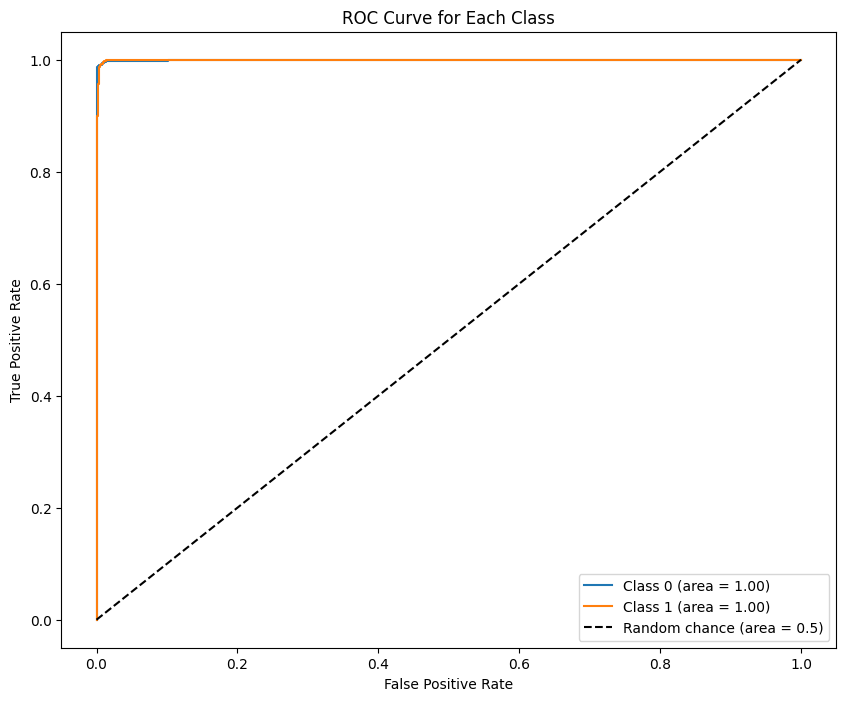

In [24]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Generate predictions for the test set
y_true = []
y_pred = []
for x, y in test_generator:
    preds = model.predict(x)
    y_pred.extend(preds)
    y_true.extend(y)
    if len(y_true) >= num_test_images:  # Stop when we have all test data
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute ROC AUC score for each class
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve for each class
n_classes = y_true.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random chance (area = 0.5)')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
#plt.show()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')  # Save the figure
plt.show()


In [26]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.utils import to_categorical

# Generate predictions for the test set
y_true = []
y_pred = []
for x, y in test_generator:
    preds = model.predict(x)
    y_pred.extend(preds)
    y_true.extend(y)
    if len(y_true) >= num_test_images:  # Stop when we have all test data
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define class labels
class_labels = {0: 'Apnea', 1: 'Non-Apnea'}

# Compute overall ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')
print(f"Overall ROC AUC Score: {roc_auc:.4f}")

# Create ROC curves for each class
n_classes = y_true.shape[1]
fig = go.Figure()

# Color palette - using medical-themed colors
colors = ['#E41A1C', '#377EB8']  # Red for Apnea, Blue for Non-Apnea

# Add ROC curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    class_auc = auc(fpr, tpr)

    fig.add_trace(go.Scatter(
        x=fpr,
        y=tpr,
        name=f'{class_labels[i]} (AUC = {class_auc:.3f})',
        line=dict(color=colors[i], width=2.5),
        hovertemplate=(
            f'{class_labels[i]}<br>'
            'False Positive Rate: %{x:.3f}<br>'
            'True Positive Rate: %{y:.3f}<br>'
            f'AUC: {class_auc:.3f}'
            '<extra></extra>'
        )
    ))

# Add random chance line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    name='Random Chance (AUC = 0.500)',
    line=dict(color='#666666', width=1.5, dash='dash'),
    hovertemplate='False Positive Rate: %{x:.3f}<br>True Positive Rate: %{y:.3f}<extra></extra>'
))

# Update layout with custom styling
fig.update_layout(
    title=dict(
        text='ROC Curve for Sleep Apnea Detection',
        x=0.5,
        y=0.95,
        xanchor='center',
        yanchor='top',
        font=dict(size=24)
    ),
    xaxis=dict(
        title=dict(
            text='False Positive Rate',
            font=dict(size=16)
        ),
        gridcolor='#eee',
        zerolinecolor='#eee',
        range=[-0.01, 1.01],
        showgrid=True
    ),
    yaxis=dict(
        title=dict(
            text='True Positive Rate',
            font=dict(size=16)
        ),
        gridcolor='#eee',
        zerolinecolor='#eee',
        range=[-0.01, 1.01],
        showgrid=True
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    hovermode='closest',
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="right",
        x=0.99,
        bgcolor='rgba(255, 255, 255, 0.9)',
        bordercolor='#ccc',
        borderwidth=1,
        font=dict(size=12)
    ),
    width=900,
    height=700,
    showlegend=True,
    margin=dict(t=100, l=100, r=50, b=100)
)

# Add light grid lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#eee', tickfont=dict(size=12))
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#eee', tickfont=dict(size=12))

# Show the plot
fig.show()

# Save as interactive HTML
fig.write_html("sleep_apnea_roc_curve_interactive.html")

# Save as high-resolution static image
# fig.write_image("sleep_apnea_roc_curve.png", scale=2)  # scale=2 for higher resolution

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Overall ROC AUC Score: 0.9997


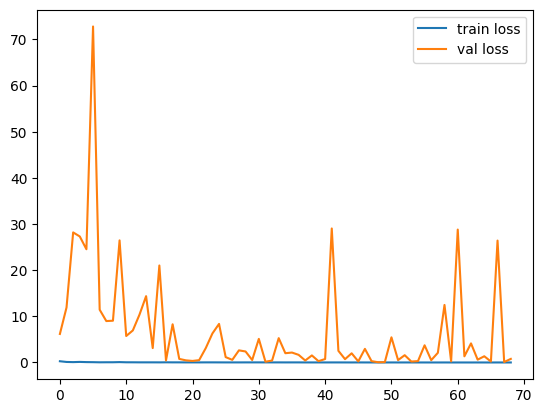

In [27]:
#loss
from matplotlib import pyplot as plt
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

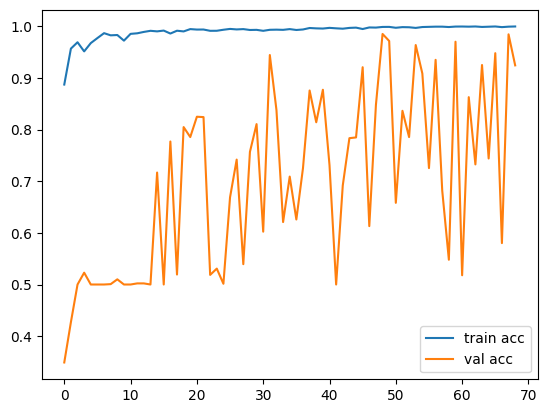

In [28]:
# acccuracy

plt.plot(r.history['accuracy'],label = 'train acc')
plt.plot(r.history['val_accuracy'],label = 'val acc')
plt.legend()
plt.show()


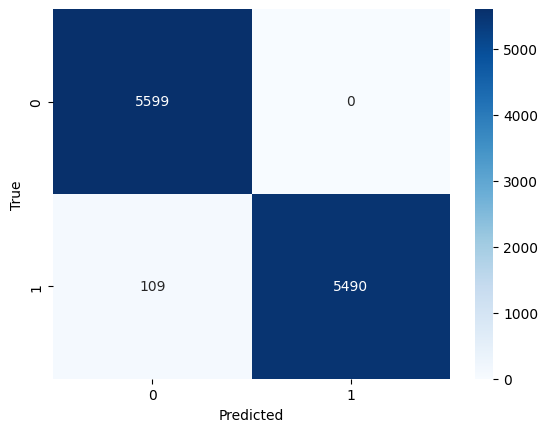

In [29]:
# visualising training cm
import seaborn as sns
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

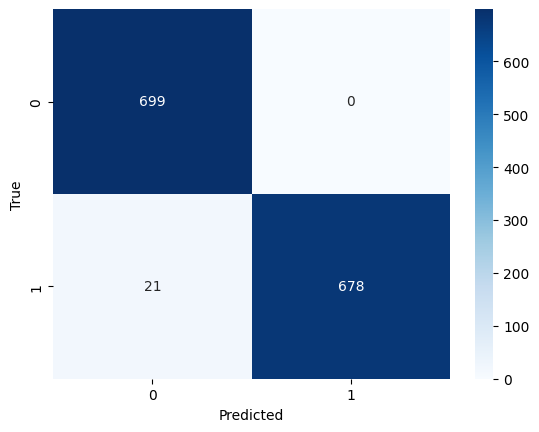

In [30]:
# visualising validation cm
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

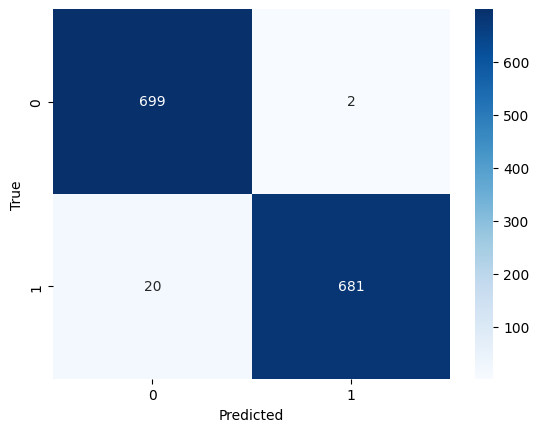

In [31]:
# visualising validation cm
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

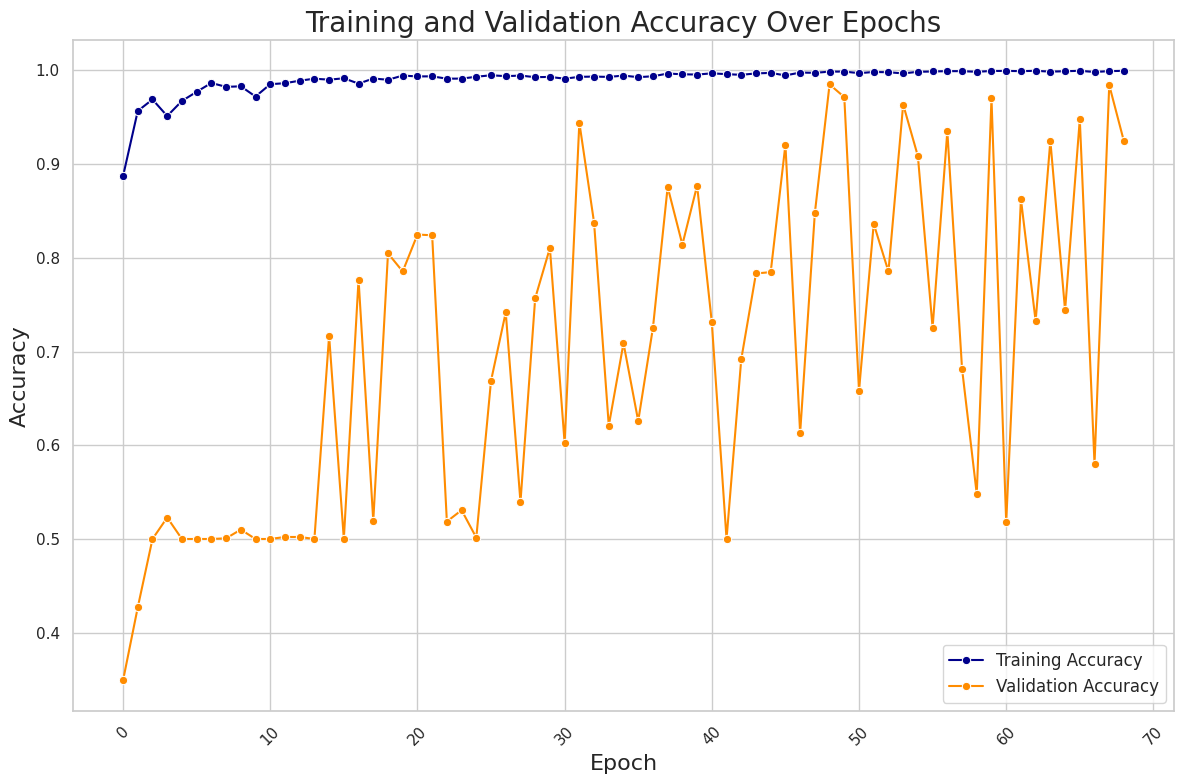

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read log file into a DataFrame
log_file_path = 'training.log'
df = pd.read_csv(log_file_path)

# Set a visually pleasing Seaborn style
sns.set(style="whitegrid")

# Create a larger figure
plt.figure(figsize=(12, 8))

# Create a line plot with Seaborn using a different color palette
sns.lineplot(x='epoch', y='accuracy', data=df, label='Training Accuracy', color='darkblue', marker='o')
sns.lineplot(x='epoch', y='val_accuracy', data=df, label='Validation Accuracy', color='darkorange', marker='o')

# Customize plot aesthetics
plt.title('Training and Validation Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Use tight layout
plt.tight_layout()

# Display the plot
plt.show()

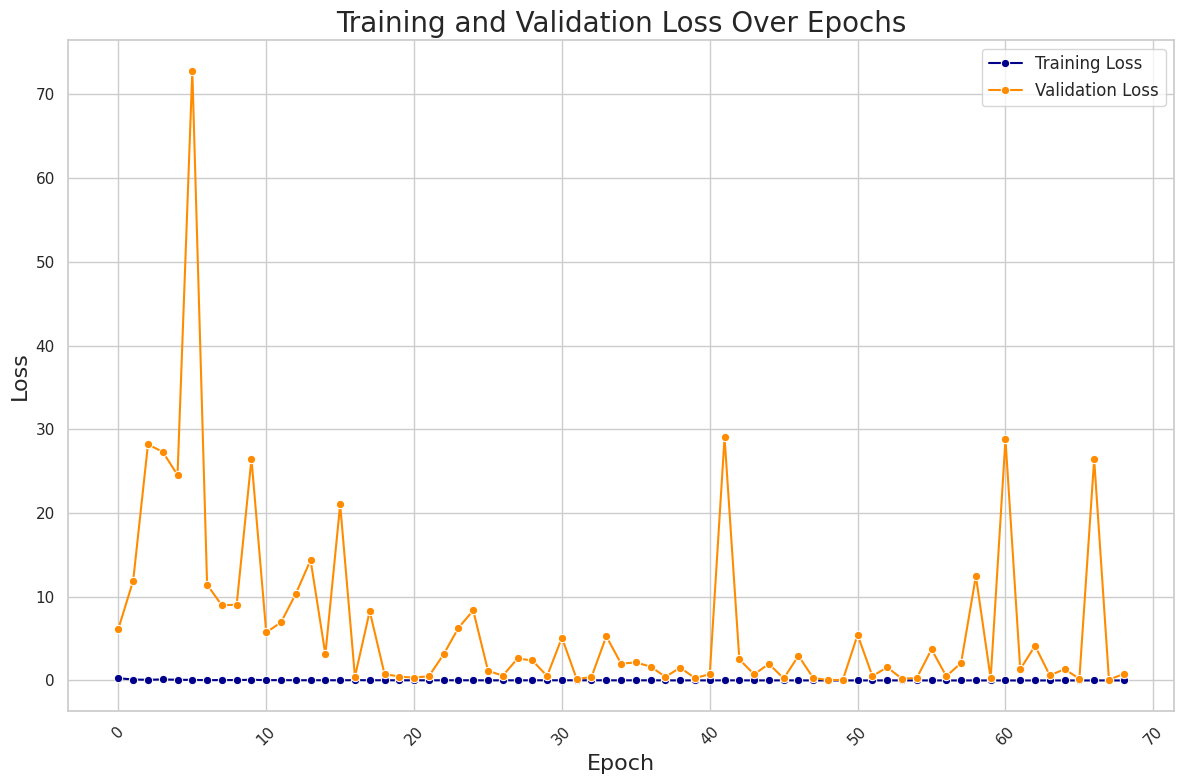

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read log file into a DataFrame
log_file_path = 'training.log'
df = pd.read_csv(log_file_path)

# Set a visually pleasing Seaborn style
sns.set(style="whitegrid")

# Create a larger figure
plt.figure(figsize=(12, 8))

# Create a line plot with Seaborn using a different color palette
sns.lineplot(x='epoch', y='loss', data=df, label='Training Loss', color='darkblue', marker='o')
sns.lineplot(x='epoch', y='val_loss', data=df, label='Validation Loss', color='darkorange', marker='o')

# Customize plot aesthetics
plt.title('Training and Validation Loss Over Epochs', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Use tight layout
plt.tight_layout()

# Display the plot
plt.show()


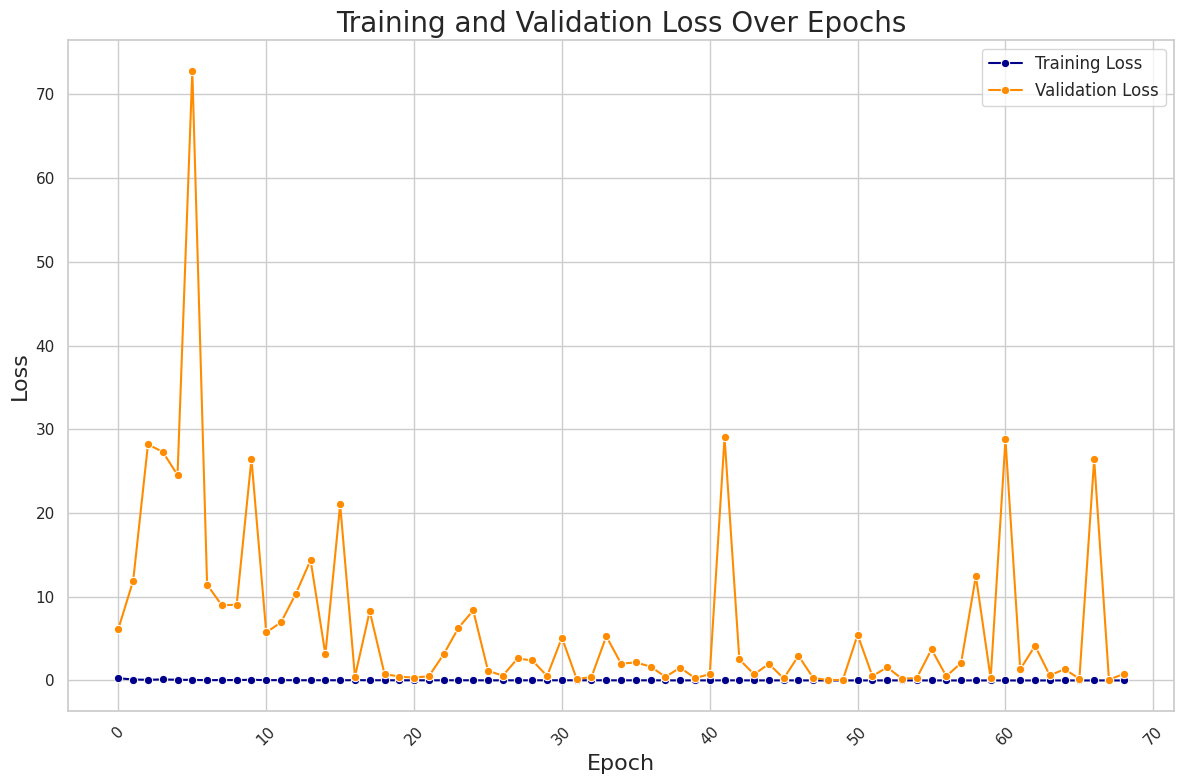

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read log file into a DataFrame
log_file_path = 'training.log'
df = pd.read_csv(log_file_path)

# Set a visually pleasing Seaborn style
sns.set(style="whitegrid")

# Create a larger figure
plt.figure(figsize=(12, 8))

# Create a line plot with Seaborn using a different color palette
sns.lineplot(x='epoch', y='loss', data=df, label='Training Loss', color='darkblue', marker='o')
sns.lineplot(x='epoch', y='val_loss', data=df, label='Validation Loss', color='darkorange', marker='o')

# Customize plot aesthetics
plt.title('Training and Validation Loss Over Epochs', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Use tight layout
plt.tight_layout()

# Display the plot
plt.show()


In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_training_validation_metrics(history):
    """
    Create customized Plotly plots for training and validation metrics.

    Parameters:
    history (dict): A dictionary containing the training history, e.g., the output of model.fit().
    """
    # Create a figure with two subplots
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss Over Epochs", "Accuracy Over Epochs"))

    # Plot the loss curves
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['loss']) + 1)), y=history['loss'], mode='lines+markers', name='Training Loss'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['val_loss']) + 1)), y=history['val_loss'], mode='lines+markers', name='Validation Loss'),
        row=1, col=1
    )

    # Plot the accuracy curves
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['accuracy']) + 1)), y=history['accuracy'], mode='lines+markers', name='Training Accuracy'),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['val_accuracy']) + 1)), y=history['val_accuracy'], mode='lines+markers', name='Validation Accuracy'),
        row=1, col=2
    )

    # Customize the layout
    fig.update_layout(
        title='Training and Validation Metrics',
        font=dict(size=14),
        xaxis1_title='Epoch',
        xaxis2_title='Epoch',
        yaxis1_title='Loss',
        yaxis2_title='Accuracy',
        width=900, height=450,
        plot_bgcolor='white',
        paper_bgcolor='white',
        margin=dict(t=50, b=50, l=50, r=50)
    )

    # Display the plot
    fig.show()

plot_training_validation_metrics(r.history)

In [36]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def plot_training_validation_metrics(history):
    """
    Create customized and enhanced Plotly plots for training and validation metrics.

    Parameters:
    history (dict): A dictionary containing the training history, e.g., the output of model.fit().
    """
    # Create a figure with two subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Loss Over Epochs", "Accuracy Over Epochs"),
        specs=[[{"type": "xy"}, {"type": "xy"}]]
    )

    # Plot the loss curves
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['loss']) + 1)), y=history['loss'], mode='lines+markers', name='Training Loss',
                   line=dict(color='#1f77b4', width=3), marker=dict(color='#1f77b4', size=10)),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['val_loss']) + 1)), y=history['val_loss'], mode='lines+markers', name='Validation Loss',
                   line=dict(color='#ff7f0e', width=3), marker=dict(color='#ff7f0e', size=10)),
        row=1, col=1
    )

    # Plot the accuracy curves
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['accuracy']) + 1)), y=history['accuracy'], mode='lines+markers', name='Training Accuracy',
                   line=dict(color='#2ca02c', width=3), marker=dict(color='#2ca02c', size=10)),
        row=1, col=2
    )
    fig.add_trace(
        go.Scatter(x=list(range(1, len(history['val_accuracy']) + 1)), y=history['val_accuracy'], mode='lines+markers', name='Validation Accuracy',
                   line=dict(color='#d62728', width=3), marker=dict(color='#d62728', size=10)),
        row=1, col=2
    )

    # Customize the layout
    fig.update_layout(
        title='Training and Validation Metrics',
        font=dict(size=16, family='Arial, sans-serif'),
        xaxis1_title='Epoch', xaxis2_title='Epoch',
        yaxis1_title='Loss', yaxis2_title='Accuracy',
        width=1200, height=600,
        plot_bgcolor='white', paper_bgcolor='white',
        margin=dict(t=50, b=50, l=50, r=50),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Add gridlines
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#f0f0f0')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#f0f0f0')

    # Add hover text
    fig.update_traces(
        hovertemplate='Epoch: %{x}<br>Value: %{y:.2f}'
    )

    # Display the plot
    fig.show()

plot_training_validation_metrics(r.history)

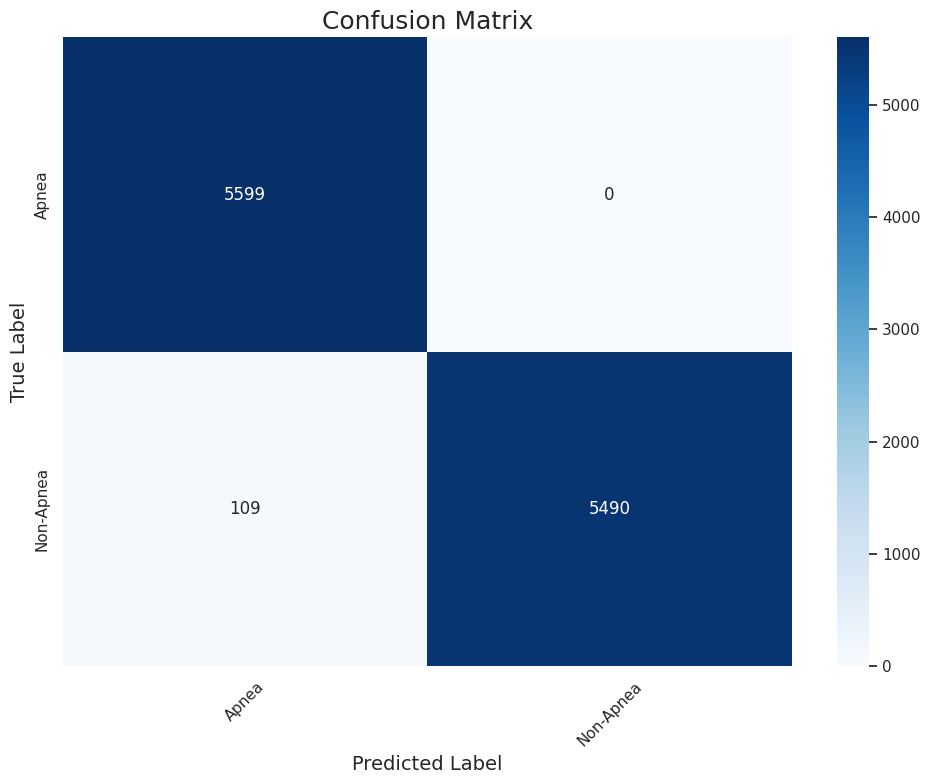

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(cm, class_labels, title='Confusion Matrix', cmap='Blues'):
    """
    Create a customized, visually enhanced confusion matrix plot.

    Parameters:
    cm (numpy.ndarray): The confusion matrix.
    class_labels (list): A list of class labels.
    title (str): The title of the plot.
    cmap (str): The colormap to use for the heatmap.
    """
    # Set the figure size
    plt.figure(figsize=(10, 8))

    # Format the class labels
    formatted_labels = [label.replace('_', ' ').title() for label in class_labels]

    # Create the confusion matrix plot
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=formatted_labels, yticklabels=formatted_labels,
                annot_kws={"size": 12})

    # Add labels and title
    plt.title(title, fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    # Add grid lines
    plt.grid(True)

    # Use tight layout
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage
plot_confusion_matrix(train_cm, ['Apnea', 'Non-Apnea'])

In [38]:
import plotly.graph_objects as go
import numpy as np

def plot_confusion_matrix(cm, class_labels, title='Confusion Matrix'):
    """
    Create a customized, visually enhanced confusion matrix plot using Plotly with percentages.

    Parameters:
    cm (numpy.ndarray): The confusion matrix.
    class_labels (list): A list of class labels.
    title (str): The title of the plot.
    """
    # Format the class labels
    formatted_labels = [label.replace('_', ' ').title() for label in class_labels]

    # Calculate the percentages
    total = np.sum(cm)
    percentages = (cm / total * 100)

    # Create the confusion matrix plot with text displaying count and percentage
    fig = go.Figure(data=go.Heatmap(
        x=formatted_labels,
        y=formatted_labels,
        z=cm,
        text=[[f'{int(count)} ({perc:.1f}%)' for count, perc in zip(row, row_perc)] for row, row_perc in zip(cm, percentages)],
        texttemplate="%{text}",  # Display the text as provided in the "text" parameter
        colorscale='Blues',
        colorbar=dict(
            title='Count',
            titleside='right',
            tickmode='array',
            tickvals=np.linspace(0, np.max(cm), 5).astype(int),
            ticktext=[str(int(x)) for x in np.linspace(0, np.max(cm), 5).astype(int)]
        ),
        hoverongaps=False
    ))

    # Add labels and title
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,
            font=dict(size=20)
        ),
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        xaxis_tickfont_size=12,
        yaxis_tickfont_size=12,
        width=800,
        height=600,
        font=dict(
            family="Arial, sans-serif",
            size=14
        )
    )

    # Show the plot
    fig.show()

# Example usage
plot_confusion_matrix(train_cm, ['Apnea', 'Non-Apnea'])


In [39]:
plot_confusion_matrix(val_cm, ['Apnea', 'Non-Apnea'])

In [40]:
plot_confusion_matrix(test_cm, ['Apnea', 'Non-Apnea'])